# About the Data

The dataset is about Exchange Rate Analysis from INR to USD. 

The data source is https://fred.stlouisfed.org/series/DEXINUS 

This has daily exchange rate information from the year 1973 till date. This has 11885 observations. 

Let's start by importing the required libraries.

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

import warnings
import time
import itertools
import datetime

%matplotlib inline

In [263]:
df = pd.read_csv('India to U.S. Foreign Exchange Rate.csv')

In [264]:
df.shape

(11885, 2)

In [265]:
df.head()

,DATE,DEXINUS
0,1973-01-02,8.02
1,1973-01-03,8.02
2,1973-01-04,8.00
3,1973-01-05,8.01
4,1973-01-08,8.00


This dataset has 11885 observations as mentioned earlier. It has two columns: one is Date column and the other is the exchange rate which is named as DEXINUS. Let's rename the column.

In [266]:
df.columns = ['DATE','Exchange_rate']

In [267]:
df.head()

,DATE,Exchange_rate
0,1973-01-02,8.02
1,1973-01-03,8.02
2,1973-01-04,8.00
3,1973-01-05,8.01
4,1973-01-08,8.00


Let's check the datatype of the columns

In [268]:
df.dtypes

DATE             object
Exchange_rate    object
dtype: object

The DATE column has object datatype, we need to change this to datetime datatype and also we need to set this column as index for time series analysis. Also we need to change the datatype of the exchange rate column from object to numeric type.

In [269]:
df['DATE'] = pd.to_datetime(df.DATE)
df = df.set_index('DATE')

In [270]:
df['Exchange_rate']= pd.to_numeric(df['Exchange_rate'], errors = 'coerce')

In [186]:
df.dtypes

Exchange_rate    float64
dtype: object

Let's check if there is any missing value in our dataframe

In [271]:
df.isnull().sum()

Exchange_rate    458
dtype: int64

We have some observations with exchange rate information missing. Let's fill in the missing values using pandas forward fill method.  

ffill: propagate last valid observation to next

In [272]:
df.fillna(method= 'ffill',  inplace=True)

In [273]:
df.isnull().sum()

Exchange_rate    0
dtype: int64

Instead of considering the 45 years history data, I feel it's more logical to consider the recent observations and last few years of data for analysis. So I will reduce my dataframe to have only last 10 years of data. 

In [274]:
df = df['2008':]

In [275]:
df.shape

(2755, 1)

Now my dataframe has 2755 observations which starts from 2008 onwards.

Let's plot the Time series data to see the trend.

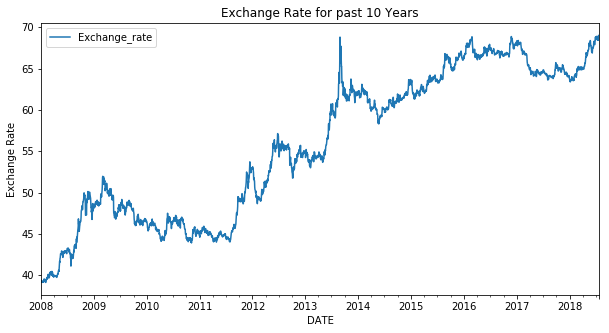

In [276]:
df.plot(figsize = (10,5));
plt.title('Exchange Rate for past 10 Years')
plt.ylabel('Exchange Rate');

The exchange rates shows volatility, but illustrates an overall increasing trend. 

Let's analyse the yearly and monthly averages of exchange rates 

In [277]:
yearly_exrate = df.groupby(df.index.year).mean()
yearly_exrate

,Exchange_rate
DATE,
2008,43.409389
2009,48.302644
2010,45.652969
2011,46.619500
2012,53.380690
2013,58.542759
2014,61.016946
2015,64.117510
2016,67.162720


In [216]:
monthly_exrate = df.groupby(df.index.month).mean()
monthly_exrate

,Exchange_rate
DATE,
1,55.280535
2,55.173246
3,55.286199
4,54.820540
5,55.782675
6,56.258697
7,56.119298
8,55.873114
9,56.315231


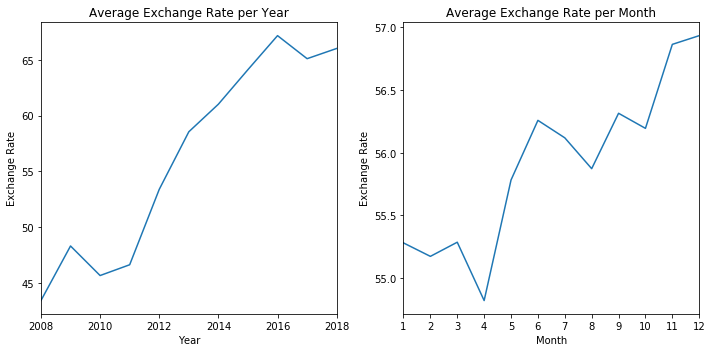

In [285]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
yearly_exrate.Exchange_rate.plot()
plt.title('Average Exchange Rate per Year')
plt.ylabel('Exchange Rate')
plt.xlabel('Year')
plt.subplot(1,2,2)
monthly_exrate.Exchange_rate.plot()
plt.title('Average Exchange Rate per Month')
plt.ylabel('Exchange Rate')
plt.xlabel('Month')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show();

From the above figure, we did not find any seasonality pattern, though the increasing trend is clear. Let's decompose the data.

# Decompose time series data

Time-series data is made up of systematic and non-systematic components. 

•	Systematic components can be modeled and include: 
	
         # Trend: direction of overall change
         # Seasonality: repeating cycles over a shorter period of time

•	Non-systematic components come from error and randomness in the data and can't be modeled.

We can use statsmodels to perform a decomposition of this time series. The decomposition of time series is a statistical task that breaks a time series into several components, each representing one of the underlying categories of patterns. With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

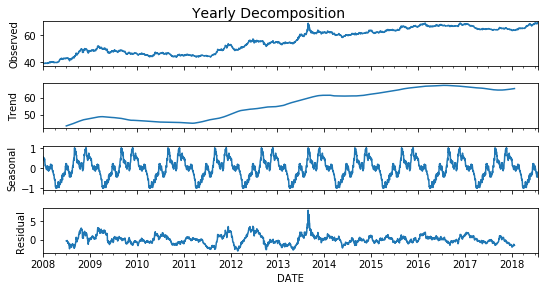

In [245]:
decomposition = seasonal_decompose(df['Exchange_rate'], freq=(5*52)) # trading days/week, 52 weeks per year
fig = decomposition.plot()
fig.set_size_inches(8,4)
fig.suptitle( 'Yearly Decomposition', x = 0.5,y = 1, fontsize= 14);

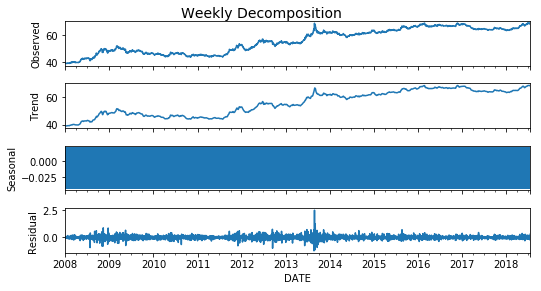

In [246]:
decomposition = seasonal_decompose(df['Exchange_rate'], freq= (5)) # trading days/week
fig = decomposition.plot()
fig.set_size_inches(8,4)
fig.suptitle( 'Weekly Decomposition', x = 0.5,y = 1, fontsize= 14);

From the above figure , we see the Weekly patterns mimics the daily data. Yearly decomposition also don't show any seasonality.
The trend is clearly an upward one.

# Stationarity Test
Before we model, it's important to test for stationarity. 
Stationarity tests a data set for mean and variance stability through time. If the mean and variance are not time dependent, the data is stationary.

The Augmented Dickey-Fuller (ADF) test is a statistical test for stationarity. 

# Augmented Dickey-Fuller (ADF) test

The Augmented Dickey-Fuller test is used to test for a unit root in a time series sample. The presence of the unit root in time series make it non-stationary (has some time-dependent structure).
The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root.

Interpretation of ADF Test result:

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Let's build the function to test for stationarity.

In [204]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics we’ll take the average/variance of the last month, i.e. last 30 days. 
    rolmean = timeseries.rolling(window=30,center=False).mean()
    rolstd = timeseries.rolling(window=30,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Data')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    # dftest[0] is test statistics value, 1 is p-value etc..
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Let's check if the actual TS data is stationary or not.

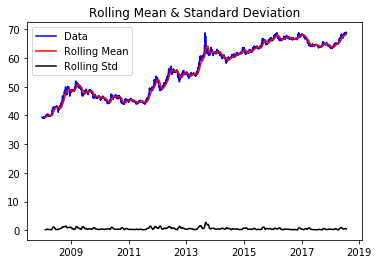

Results of Dickey-Fuller Test:
Test Statistic                   -1.281828
p-value                           0.637444
#Lags Used                        5.000000
Number of Observations Used    2749.000000
Critical Value (1%)              -3.432731
Critical Value (5%)              -2.862592
Critical Value (10%)             -2.567330
dtype: float64


In [205]:
test_stationarity(df['Exchange_rate'])

The results of the ADF tests indicate that our data sets is not stationary. So we will first try taking the first order difference of the time series data. and do stationarity test on that.

In [248]:
first_diff = df['Exchange_rate'] - df['Exchange_rate'].shift()

In [249]:
first_diff.head()

DATE
2008-01-01     NaN
2008-01-02    0.00
2008-01-03   -0.15
2008-01-04   -0.11
2008-01-07    0.00
Name: Exchange_rate, dtype: float64

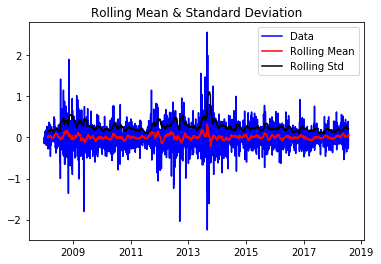

Results of Dickey-Fuller Test:
Test Statistic                  -22.092389
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    2749.000000
Critical Value (1%)              -3.432731
Critical Value (5%)              -2.862592
Critical Value (10%)             -2.567330
dtype: float64


In [250]:
first_diff.dropna(inplace=True)
test_stationarity(first_diff)

The results show that the time series data became stationary after taking the first order difference. 

Now let's see how the ACF and PACF plot looks like.

# ACF

Autocorrelation Function: It is a measure of the correlation between the Time series with a lagged version of itself.

# PACF

Partial Autocorrelation Function : This measures the correlation between the Time series with a lagged version of itself but after eliminating the variations already explained by the shorter lags.

Plots are showing the lag values along the x-axis and the correlation on the y-axis. Confidence intervals are shown in blue dotted lines. This is set to a 95% confidence interval. Any lag beyond the CI is considered to be significant.

Now generate and Interpret the ACF and PACF for first order differenced data.

In [251]:
x_acf = pd.DataFrame(acf(first_diff))
x_pacf = pd.DataFrame(pacf(first_diff))

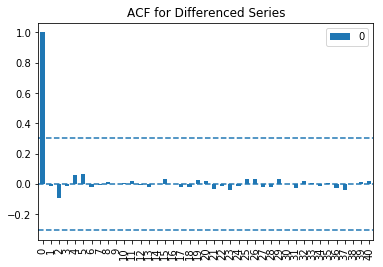

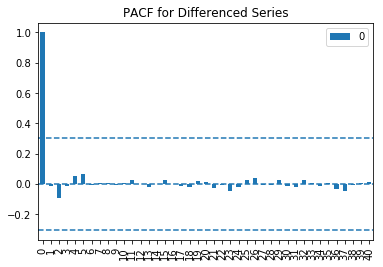

In [252]:
x_acf.plot(kind='bar')
plt.axhline(y=0, linestyle= '--')
plt.axhline(y= - 1.96 / np.sqrt(len(x_acf)), linestyle = '--')
plt.axhline(y= 1.96 / np.sqrt(len(x_acf)), linestyle = '--')
plt.title('ACF for Differenced Series')
plt.show()

x_pacf.plot(kind='bar')
plt.axhline(y=0, linestyle= '--')
plt.axhline(y= - 1.96 / np.sqrt(len(x_pacf)), linestyle = '--')
plt.axhline(y= 1.96 / np.sqrt(len(x_pacf)), linestyle = '--')
plt.title('PACF for Differenced Series')
plt.show()

The ACF and PACF plot does not show any significant lag after lag 0.


Let's try taking the second order difference and check the ACF and PACF plot for this.

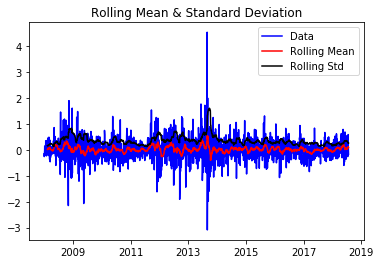

Results of Dickey-Fuller Test:
Test Statistic                -1.031000e+01
p-value                        3.203941e-18
#Lags Used                     2.500000e+01
Number of Observations Used    2.727000e+03
Critical Value (1%)           -3.432750e+00
Critical Value (5%)           -2.862600e+00
Critical Value (10%)          -2.567335e+00
dtype: float64
None


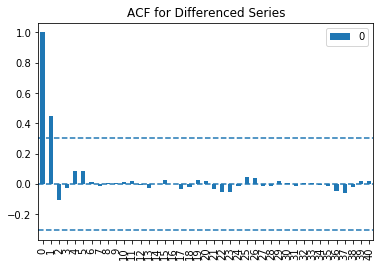

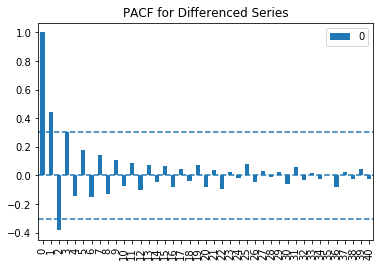

In [253]:
second_diff = df['Exchange_rate'].diff(2)
second_diff.dropna(inplace=True)
print(test_stationarity(second_diff))
x_acf = pd.DataFrame(acf(second_diff))
x_pacf = pd.DataFrame(pacf(second_diff))

x_acf.plot(kind='bar')
plt.axhline(y=0, linestyle= '--')
plt.axhline(y= - 1.96 / np.sqrt(len(x_acf)), linestyle = '--')
plt.axhline(y= 1.96 / np.sqrt(len(x_acf)), linestyle = '--')
plt.title('ACF for Differenced Series')
plt.show()

x_pacf.plot(kind='bar')
plt.axhline(y=0, linestyle= '--')
plt.axhline(y= - 1.96 / np.sqrt(len(x_pacf)), linestyle = '--')
plt.axhline(y= 1.96 / np.sqrt(len(x_pacf)), linestyle = '--')
plt.title('PACF for Differenced Series')
plt.show()

The above ACF plot suggests MA of order 1 and PACF plot suggests AR of order 2 could be a reasonable starting parameters for ARIMA modelling.

# AutoRegressive Integrated Moving Average (ARIMA) Model

ARIMA model enables to use linear regression models on non-stationary data.

$AR: Autoregression$: 

A model that uses the relationship between an observation and some number of lagged observations.

$I: Integrated$:

The use of differencing of raw observations in order to make the time series stationary.

$MA: Moving Average$: 

A model that uses the dependency between an observation and past error.    

ARIMA models are denoted with the notation $ARIMA (p, d, q)$. 

p : Number of AR (Auto-Regressive) terms  -  the number of lag observations to include in the model

d : the number of times that the raw observations are differenced, or the degree of differencing. 

q : Number of MA (Moving Average) terms 
    

# Model Preparation

Let's start creating training and testing data. Unlike traditional supervised learning models where we randomly split the data, our training and testing data sets needs to remain sequential to preserve time dependency. We will take the last 90 observations as the test data and remaining as training data.

In [10]:
arima_train_data = df.Exchange_rate[:-90]
arima_test_data = df.Exchange_rate[-90:]
print('Train Data Size ', arima_train_data.shape[0])
print('Test Data Size ', arima_test_data.shape[0])

Train Data Size  2665
Test Data Size  90


Next we'll build a functions to fit and test various ARIMA configurations to determine the best model for the data. Typically, we'd look to the AIC value to evalute a model, choosing the model configuration with the lowest AIC score. As another metric,  we have stored the MSE results too in the dataframe.

# AIC
Akaike information criteria : provides a way of model selection. When there are different models for data, we choose the model with lowest AIC as the best model.

# Walk Forward Validation

A rolling-forecast scenario also called walk-forward model validation is the recommended method for constructing machine learning models dedicated to time-series data. Walk-forward validation provides the most realistic evaluation of machine learning models since k-fold cross validation does not work for time series data.

Each time step of the test dataset is walked one at a time. A model is used to make a forecast for the time step, then the predicted value is taken and made available to the model for the forecast on the next time step.

Basically the model is updated each time step new data is received.


In [216]:
warnings.filterwarnings('ignore')

arima_aic_list = []
arima_mse_list = []
arima_param_list = []

# Function to generate predictions for a given arima order
def evaluate_arima(train, test, arima_order):
    
    # Populate history based on training set
    history = [x for x in train]    
    # Create blank list of predictions to populate
    predictions = list()
    
    # Use rolling forward walk predictions.  Fit model using history,
    # adding each prediction to history to continue forecasting
    
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        aic_val = model_fit.aic
        # Get prediction
        y_pred = model_fit.forecast()[0]        
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)        
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
    
    error = mean_squared_error(test, predictions)
    
    return error, aic_val

# Function to determine best arima order combination based on lowest MSE
def arima_gridsearch(train, test, p_vals, d_vals, q_vals):
    
    arima_order_list =  list(itertools.product(p_vals, d_vals, q_vals))
    arima_order_list.remove((0, 0, 0))  
    arima_order_list.remove((0, 1, 0))
             
    for arima_order in arima_order_list:
               
        try:
            print('Executing order ', arima_order)
            mse, aic_val = evaluate_arima(train, test, arima_order)
            arima_param_list.append(arima_order)
            arima_aic_list.append(aic_val)
            arima_mse_list.append(mse)
            
                    
        except (ValueError, np.linalg.LinAlgError): # ignore non converging errors
            pass          


Let's start ARIMA modelling for a range of p, d and q values. The results are stored in a dataframe for further reference.

In [217]:
tstart = time.time()
arima_gridsearch(arima_train_data, arima_test_data,range(4),range(3),range(4) )
tend = time.time() 
print('Total Execution Time in seconds', tend - tstart)

Executing order  (0, 0, 1)
Executing order  (0, 0, 2)
Executing order  (0, 0, 3)
Executing order  (0, 1, 1)
Executing order  (0, 1, 2)
Executing order  (0, 1, 3)
Executing order  (0, 2, 0)
Executing order  (0, 2, 1)
Executing order  (0, 2, 2)
Executing order  (0, 2, 3)
Executing order  (1, 0, 0)
Executing order  (1, 0, 1)
Executing order  (1, 0, 2)
Executing order  (1, 0, 3)
Executing order  (1, 1, 0)
Executing order  (1, 1, 1)
Executing order  (1, 1, 2)
Executing order  (1, 1, 3)
Executing order  (1, 2, 0)
Executing order  (1, 2, 1)
Executing order  (1, 2, 2)
Executing order  (1, 2, 3)
Executing order  (2, 0, 0)
Executing order  (2, 0, 1)
Executing order  (2, 0, 2)
Executing order  (2, 0, 3)
Executing order  (2, 1, 0)
Executing order  (2, 1, 1)
Executing order  (2, 1, 2)
Executing order  (2, 1, 3)
Executing order  (2, 2, 0)
Executing order  (2, 2, 1)
Executing order  (2, 2, 2)
Executing order  (2, 2, 3)
Executing order  (3, 0, 0)
Executing order  (3, 0, 1)
Executing order  (3, 0, 2)
E

In [218]:
arima_model_output_df = pd.DataFrame({'AIC' :arima_aic_list ,'MSE': arima_mse_list , 'Param': arima_param_list})

In [219]:
arima_model_output_df.to_csv('Arima_Model_exchange_rate_2.csv')

In [36]:
arima_model_output_df = pd.read_csv('Arima_Model_exchange_rate_2.csv', usecols = ['AIC','MSE','Param'])

In [220]:
arima_model_output_df.sort_values(by= 'AIC', ascending=True).head(5)

,AIC,MSE,Param
18,907.173651,3.373355,"(2, 1, 2)"
25,907.673733,3.361100,"(3, 1, 2)"
16,918.157004,3.398526,"(2, 1, 0)"
23,919.134121,3.415869,"(3, 1, 0)"
17,919.695898,3.407183,"(2, 1, 1)"


In [221]:
arima_model_output_df.sort_values(by= 'MSE', ascending=True).head(5)

,AIC,MSE,Param
11,940.706970,3.335052,"(1, 1, 0)"
1,940.608592,3.337165,"(0, 1, 1)"
25,907.673733,3.361100,"(3, 1, 2)"
18,907.173651,3.373355,"(2, 1, 2)"
12,937.099980,3.384456,"(1, 1, 1)"



We'll also build function to examine residuals from the optimized model configuration. Examining the residuals in an ARIMA model is an important step because the model is based on a linear regression and the underlying assumptions of a linear regression. Ideally, we want to see that our error terms are random and normally distributed.

We'll also build function to plot the predictions, to have a look at our predictions.

In [25]:
# Function to evaluate residuals

def plot_residuals(train, p, d, q):
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit()
    residuals = model_fit.resid
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.title('ARIMA Residuals')
    residuals.plot()
    
    plt.subplot(1,3,2)
    residuals.hist()    
    plt.title('ARIMA Residual Histogram')
    
    plt.subplot(1,3,3)    
    resid_acf = acf(residuals)
    plt.bar(left = range(len(resid_acf)), height = resid_acf)
    plt.axhline(y=0, linestyle= '--')
    plt.axhline(y= - 1.96 / np.sqrt(len(resid_acf)), linestyle = '--')
    plt.axhline(y= 1.96 / np.sqrt(len(resid_acf)), linestyle = '--')
    plt.title('ACF for Residuals')
    plt.show()

# Function to plot predictions
def plot_predictions(train, test, p, d, q):

    arima_order = (p,d,q)    
    history = [x for x in train]        
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        y_pred = model_fit.forecast()[0]    
        predictions.append(y_pred)
        history.append(y_pred)
    
        
    # Plots
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('ARIMA Forecast - Full Time Series')
    plt.ylabel('Exchange Rate')
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.subplot(122)
    plt.autoscale()
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('ARIMA - Compare forecast for the test period')
    plt.ylabel('Exchange Rate')
    plt.ylim(min(predictions) - 5, max(predictions) + 5)
    plt.xlim([datetime.date(2018, 5, 1), datetime.date(2018, 7, 23)])
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.tight_layout()

# ARIMA Best Model - Lowest MSE

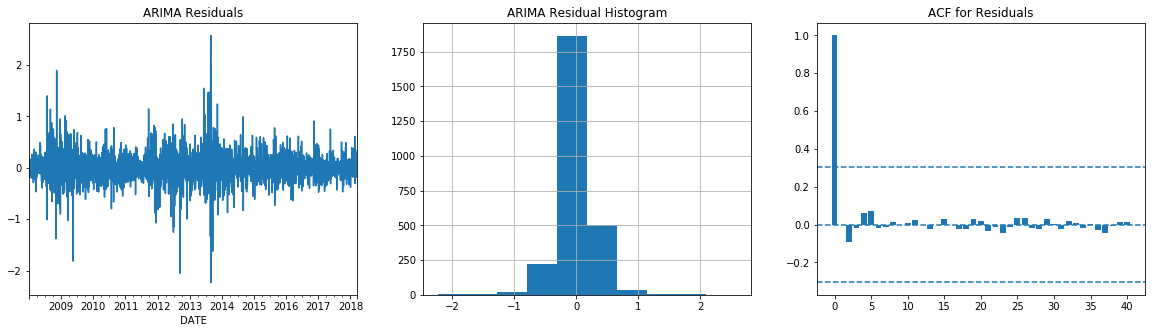

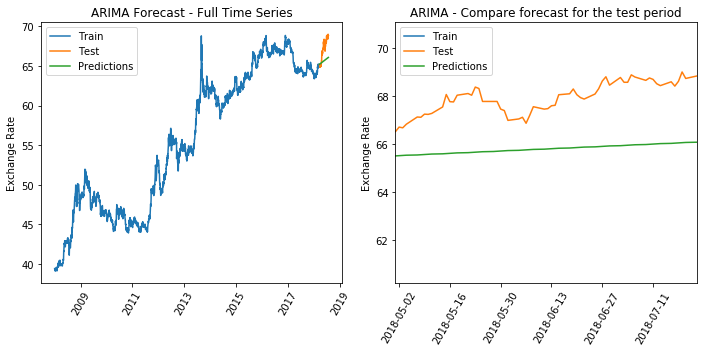

In [29]:
warnings.filterwarnings('ignore')
plot_residuals(arima_train_data, 1,1,0)
plot_predictions(arima_train_data, arima_test_data, 1,1,0)

The residuals are normally distributed and the ACF plot of residuals also dont show any significant lag. This satisfies the model assumptions.

# ARIMA Best Model - Lowest AIC

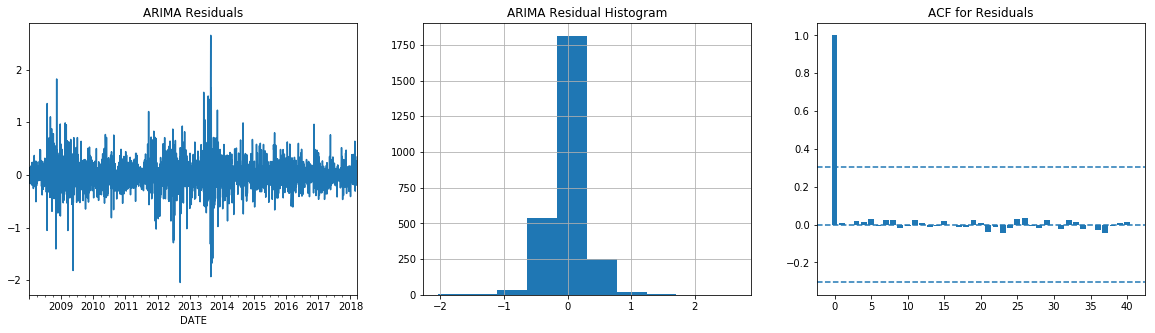

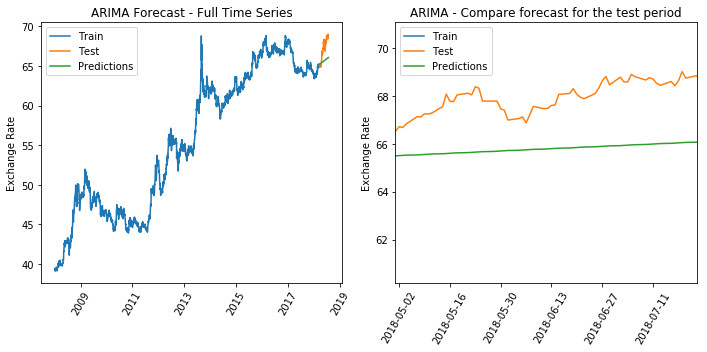

In [30]:
warnings.filterwarnings('ignore')
plot_residuals(arima_train_data, 2,1,2)
plot_predictions(arima_train_data, arima_test_data, 2,1,2)

The residuals are normally distributed and the ACF plot of residuals also dont show any significant lag. This satisfies the model assumptions.

# AUTO ARIMA

 auto_arima function allows us to set a range of p, d, q, P, D and Q values and then fit models for all the possible combinations. Then the model will keep the combination that reported back the best AIC (lowest AIC) value.

   The pyramid-arima library for Python allows us to quickly perform this grid search and even creates a model object that can fit to the training data.

Other Parameters:

  m : The period for seasonal differencing. Default is 1. 
  
  Note that if m == 1 (i.e., is non-seasonal), seasonal will be set to False.
    
  seasonal : Whether to fit a seasonal ARIMA. Default is True. Note that if seasonal is True and m == 1, seasonal will be set to False.
    
   stepwise : The stepwise algorithm can be significantly faster than fitting all (or a random subset of) hyper-parameter combinations and is less likely to over-fit the model.

In [11]:
from pyramid.arima import auto_arima

Let's build the function for plotting the residuals and predictions of auto_arima. We will use this once our model is fitted to the data.

In [12]:
def plot_auto_arima_residuals(fitted_model):
    
    auto_arima_residuals = pd.DataFrame(fitted_model.resid(), index = arima_train_data.index, columns = ['Rate'])
       
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(auto_arima_residuals.index, auto_arima_residuals.Rate)
    plt.title('Auto Arima Residuals')
        
    plt.subplot(1,3,2)
    plt.hist(auto_arima_residuals.Rate)
    plt.title('Auto Arima Residual Histogram')
    
    plt.subplot(1,3,3)    
    resid_acf = acf(fitted_model.resid())
    plt.bar(left = range(len(resid_acf)), height = resid_acf)
    plt.axhline(y=0, linestyle= '--')
    plt.axhline(y= - 1.96 / np.sqrt(len(resid_acf)), linestyle = '--')
    plt.axhline(y= 1.96 / np.sqrt(len(resid_acf)), linestyle = '--')
    plt.title('ACF for Residuals')
    
    plt.show()
    
def plot_auto_arima_predictions (predictions):
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(arima_train_data.index, arima_train_data, label='Train')
    plt.plot(arima_test_data.index, arima_test_data, label='Test')
    plt.plot(arima_test_data.index, predictions, label='Predictions')
    plt.title('Auto Arima Forecast - Full Time Series')
    plt.ylabel('Exchange Rate')
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.subplot(122)
    plt.autoscale()
    plt.plot(arima_train_data.index, arima_train_data, label='Train')
    plt.plot(arima_test_data.index, arima_test_data, label='Test')
    plt.plot(arima_test_data.index, predictions, label='Predictions')
    plt.title('Auto Arima - Compare forecast for the test period')
    plt.ylabel('Exchange Rate')
    plt.ylim(min(predictions) - 5, max(predictions) + 5)
    plt.xlim([datetime.date(2018, 5, 1), datetime.date(2018, 7, 23)])
    plt.xticks(rotation=60)
    plt.legend()
    

Let's try auto arima with seasonality period of 30. 

In [13]:
tstart = time.time()
stepwise_fit_30 = auto_arima(arima_train_data,  start_p=1, start_q=1, max_p=3, max_q=3, m=30,
                          start_P=0, start_Q=0 ,seasonal=True, d=1, D=0, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise
           
print(stepwise_fit_30.summary())

tend = time.time() 
print('Total Execution Time in seconds', tend - tstart)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 30); AIC=994.609, BIC=1018.160, Fit time=1.873 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 30); AIC=996.444, BIC=1008.219, Fit time=0.389 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 30); AIC=1000.020, BIC=1023.570, Fit time=3.304 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 30); AIC=999.924, BIC=1023.474, Fit time=5.303 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 30); AIC=996.594, BIC=1026.032, Fit time=9.307 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 30); AIC=996.594, BIC=1026.032, Fit time=20.353 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 30); AIC=998.595, BIC=1033.920, Fit time=14.907 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 30); AIC=997.940, BIC=1015.603, Fit time=0.432 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 30); AIC=977.833, BIC=1007.271, Fit time=1.403 seconds
Fit ARIMA: order=(2, 1, 0) seasona

The auto arima predicted a model with AR of order 2 with first order difference. Let's check the residuals and predictions.

In [14]:
auto_arima_30_aic = stepwise_fit_30.aic()
print('AIC: ' , auto_arima_30_aic)
auto_arima_30_y_pred = stepwise_fit_30.predict(n_periods=90)
auto_arima_30_mse = mean_squared_error(arima_test_data, auto_arima_30_y_pred)
print('MSE ',auto_arima_30_mse) 
auto_arima_30_model = 'SARIMAX(2, 1, 0)'

AIC:  976.279331139
MSE  3.39953129436


C:\Users\gyans\Anaconda3\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


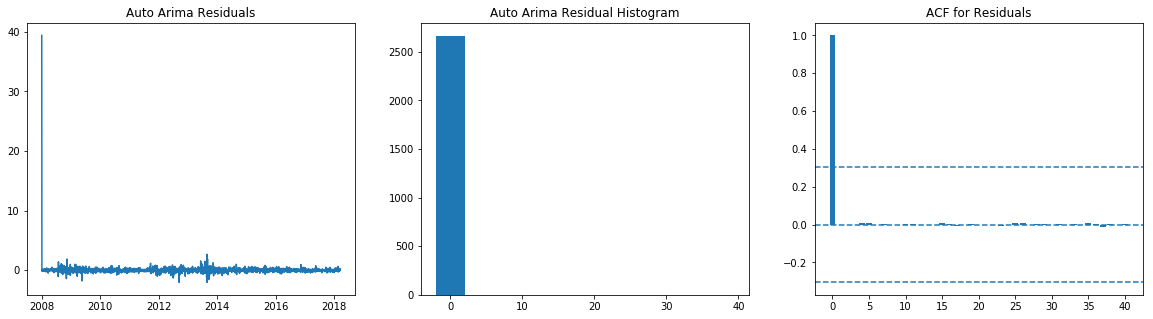

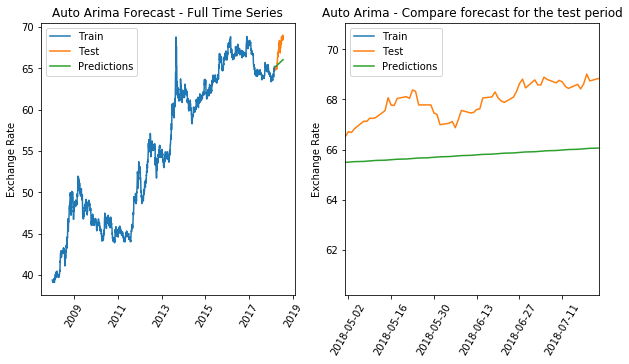

In [15]:
plot_auto_arima_residuals(stepwise_fit_30)
plot_auto_arima_predictions(auto_arima_30_y_pred )

The residuals are normally distributed and the ACF plot of residuals also dont show any significant lag. This satisfies the model assumptions.

Let's run the auto arima for seasonality period of 7

In [16]:
tstart = time.time()
stepwise_fit_7 = auto_arima(arima_train_data,  start_p=1, start_q=1, max_p=3, max_q=3, m=7,
                          start_P=0, start_Q=0 ,seasonal=True, d=1, D=0, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

print(stepwise_fit_7.summary())

tend = time.time() 
print('Total Execution Time in seconds', tend - tstart)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=994.609, BIC=1018.160, Fit time=1.295 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=996.444, BIC=1008.219, Fit time=0.447 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=999.709, BIC=1023.260, Fit time=1.119 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=999.611, BIC=1023.161, Fit time=0.903 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=996.407, BIC=1025.845, Fit time=2.111 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=996.406, BIC=1025.844, Fit time=2.064 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=998.400, BIC=1033.725, Fit time=2.414 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=997.940, BIC=1015.603, Fit time=0.448 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=977.833, BIC=1007.271, Fit time=1.379 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 

In [17]:
auto_arima_aic_7 = stepwise_fit_7.aic()
print('AIC: ' , auto_arima_aic_7)
auto_arima_7_y_pred = stepwise_fit_7.predict(n_periods=90)
auto_arima_7_mse = mean_squared_error(arima_test_data, auto_arima_7_y_pred)
print('MSE ',auto_arima_7_mse) 
auto_arima_7_model = 'SARIMAX(2, 1, 0)'

AIC:  976.279331139
MSE  3.39953129436


C:\Users\gyans\Anaconda3\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


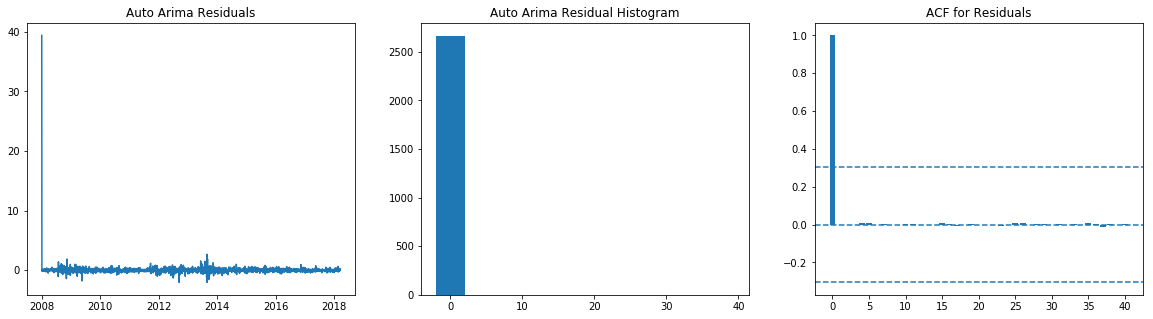

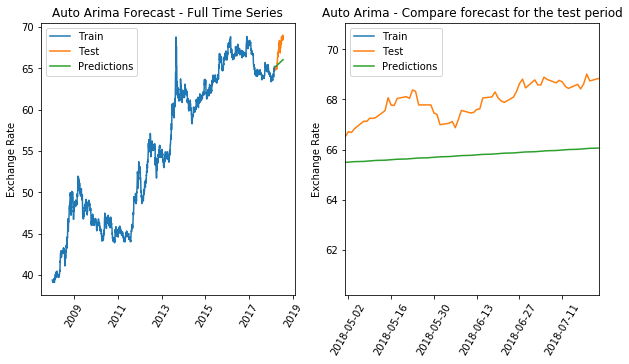

In [18]:
plot_auto_arima_residuals(stepwise_fit_7)
plot_auto_arima_predictions(auto_arima_7_y_pred )

This time also the auto arima model predicted the same as before when we tried different seasonality period.
The residuals are normally distributed and the ACF plot of residuals also dont show any significant lag. This satisfies the model assumptions.

Let's try without any seasonality period.

In [43]:
tstart = time.time()
stepwise_fit_1 = auto_arima(arima_train_data,  start_p=1, start_q=1, max_p=3, max_q=3, m=1,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

print(stepwise_fit_1.summary())

tend = time.time() 
print('Total Execution Time in seconds', tend - tstart)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=994.609, BIC=1018.160, Fit time=1.160 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=996.444, BIC=1008.219, Fit time=0.382 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=998.035, BIC=1015.698, Fit time=1.530 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=997.940, BIC=1015.603, Fit time=0.375 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=977.833, BIC=1007.271, Fit time=1.313 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=976.279, BIC=999.830, Fit time=0.374 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=978.341, BIC=1013.666, Fit time=1.605 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=977.290, BIC=1006.728, Fit time=0.485 seconds
Total fit time: 7.227 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. 

In [44]:
auto_arima_aic_1 = stepwise_fit_1.aic()
print('AIC: ' , auto_arima_aic_1)
auto_arima_1_y_pred = stepwise_fit_1.predict(n_periods=90)
auto_arima_1_mse = mean_squared_error(arima_test_data, auto_arima_1_y_pred)
print('MSE ',auto_arima_1_mse) 
auto_arima_1_model = 'SARIMAX(2, 1, 0)'

AIC:  976.279331139
MSE  3.39953129436


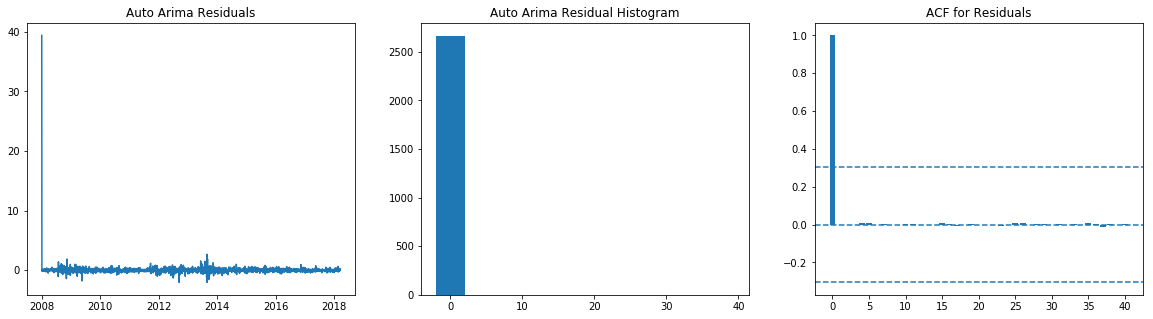

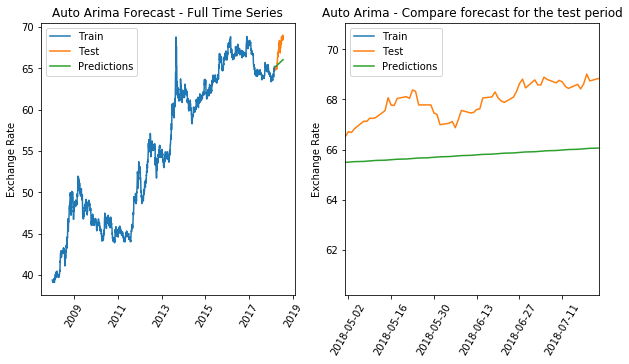

In [41]:
plot_auto_arima_residuals(stepwise_fit_1)
plot_auto_arima_predictions(auto_arima_1_y_pred )

This time also the residuals are normally distributed and the ACF plot of residuals also dont show any significant lag. This satisfies the model assumptions.
and also the predictions did not change though we tried different seasonality periods.

The auto arima predicted AR of order 2 with first order difference as the best model.

# PROPHET

•	Prophet is a package developed by Facebook for forecasting time series data. 

•	It is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

•	It works best with time series that have strong seasonal effects and several seasons of historical data. 

•	Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. 

•	Prophet allows to include holidays and other special events.


More information can be found at
https://facebook.github.io/prophet/ and
https://research.fb.com/prophet-forecasting-at-scale/



In [47]:
from fbprophet import Prophet

In [254]:
df.head()

,Exchange_rate
DATE,
2008-01-01,39.41
2008-01-02,39.41
2008-01-03,39.26
2008-01-04,39.15
2008-01-07,39.15


In [255]:
df_p = df.reset_index()

In [45]:
df_p.head()

,DATE,Exchange_rate
0,2008-01-01,39.41
1,2008-01-02,39.41
2,2008-01-03,39.26
3,2008-01-04,39.15
4,2008-01-07,39.15


Prophet requires specific input format. Columns names must be lowercase, date column should be named as 'ds', data as 'y'. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [50]:
prophet_df = df_p.rename(columns={'DATE': 'ds', 'Exchange_rate': 'y'})
prophet_df.head()

,ds,y
0,2008-01-01,39.41
1,2008-01-02,39.41
2,2008-01-03,39.26
3,2008-01-04,39.15
4,2008-01-07,39.15


Let's split the data into train/test sets. Take last 90 days as test data

In [51]:
df_prophet_train = prophet_df[:-90]
df_prophet_test = prophet_df[-90:]
print(df_prophet_train.shape)
print(df_prophet_test.shape)

(2665, 2)
(90, 2)


In [48]:
df_prophet_train.head()

,ds,y
0,2008-01-01,39.41
1,2008-01-02,39.41
2,2008-01-03,39.26
3,2008-01-04,39.15
4,2008-01-07,39.15


# Prophet with default parameters

In [181]:
prophet_model = Prophet()
prophet_model.fit(df_prophet_train)
future = prophet_model.make_future_dataframe(periods = 123)
forecast = prophet_model.predict(future)
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

• ds: the datestamp of the forecasted value

• yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)

• yhat_lower: the lower bound of our forecasts

• yhat_upper: the upper bound of our forecasts

In [182]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2008-01-01,38.481194,38.481194,38.481194,37.870246,40.163154,0.531103,0.531103,0.531103,0.0,0.0,0.0,-0.127781,-0.127781,-0.127781,0.658883,0.658883,0.658883,39.012297
1,2008-01-02,38.508359,38.508359,38.508359,37.863471,40.157803,0.516503,0.516503,0.516503,0.0,0.0,0.0,-0.131860,-0.131860,-0.131860,0.648362,0.648362,0.648362,39.024862
2,2008-01-03,38.535524,38.535524,38.535524,37.945544,40.156934,0.495784,0.495784,0.495784,0.0,0.0,0.0,-0.139740,-0.139740,-0.139740,0.635524,0.635524,0.635524,39.031308
3,2008-01-04,38.562689,38.562689,38.562689,37.890657,40.145529,0.438512,0.438512,0.438512,0.0,0.0,0.0,-0.181901,-0.181901,-0.181901,0.620413,0.620413,0.620413,39.001201
4,2008-01-07,38.644183,38.644183,38.644183,37.965422,40.240672,0.417272,0.417272,0.417272,0.0,0.0,0.0,-0.145310,-0.145310,-0.145310,0.562582,0.562582,0.562582,39.061455


We can plot the forecast by calling the model.plot method and passing in our forecast dataframe.

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

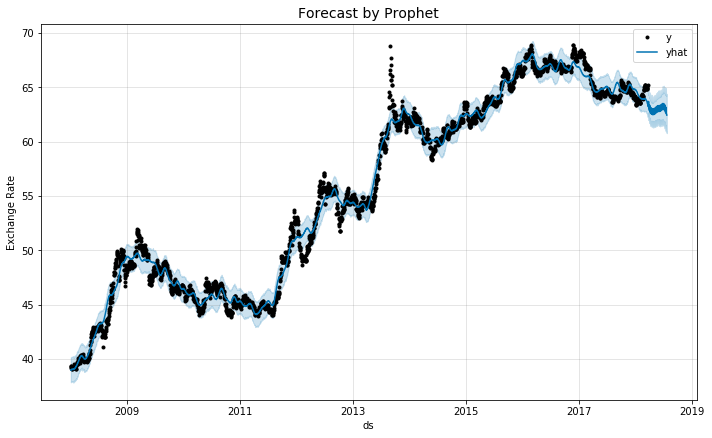

In [183]:
prophet_model.plot(forecast, uncertainty=True)
plt.title('Forecast by Prophet', fontsize=14)
plt.legend()
plt.ylabel('Exchange Rate')
plt.show()

Let's build the function to plot the predictions

In [52]:
def plot_prophet_predictions():
    
    print()
    print('\t \t\t \t \t Prophet Model \t\t \t\t \t')
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(df_prophet_train.ds, df_prophet_train.y, label='Train')
    plt.plot(df_prophet_test.ds, df_prophet_test.y, label='Test')
    plt.plot(forecast.ds, forecast.yhat, label='Predictions')
    plt.title('Forecast - Full Time Series')
    plt.ylabel('Exchange Rate')
    plt.xticks(rotation=60)
    plt.legend()
       
    plt.subplot(122)
    plt.autoscale()
    plt.plot(df_prophet_train.ds, df_prophet_train.y, label='Train')
    plt.plot(df_prophet_test.ds, df_prophet_test.y, label='Test')
    plt.plot(forecast.ds, forecast.yhat, label='Predictions')
    plt.fill_between(
        forecast_ci.index.to_pydatetime(),
        forecast_ci['yhat_lower'],
        forecast_ci['yhat_upper'],
        color='b',
        alpha=0.1)
    plt.title('Compare forecast for the test period')
    
    plt.ylim(min(forecast.yhat) - 5, max(forecast.yhat) + 5)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 7, 23)])
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.tight_layout()


	 		 	 	 Prophet Model 		 		 	


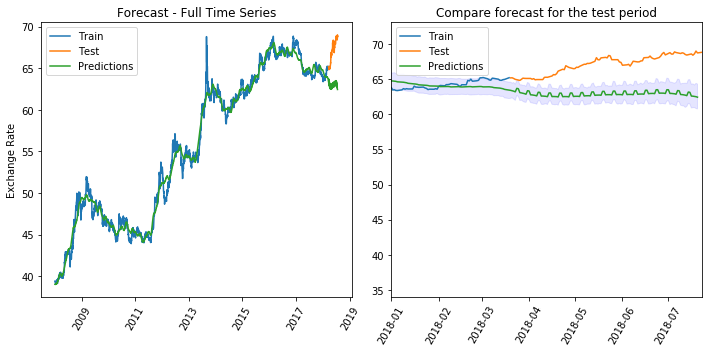

In [184]:
plot_prophet_predictions()

In [186]:
print(forecast.shape)
print(len(df_prophet_test))
print(len(df_prophet_train))

(2788, 19)
90
2665


In [187]:
# Calculate MSE 
results = forecast[['ds', 'yhat']].merge(prophet_df, on='ds')
prophet_default_mse = mean_squared_error(results.y, results.yhat)
print('MSE: ',prophet_default_mse )

MSE:  1.42684005445


# Prophet with parameter tuning

In [188]:
prophet_model = Prophet(yearly_seasonality=False,
                        weekly_seasonality=False,
                        daily_seasonality=False)

prophet_model.fit(df_prophet_train)
future = prophet_model.make_future_dataframe(periods=123)
forecast = prophet_model.predict(future)
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

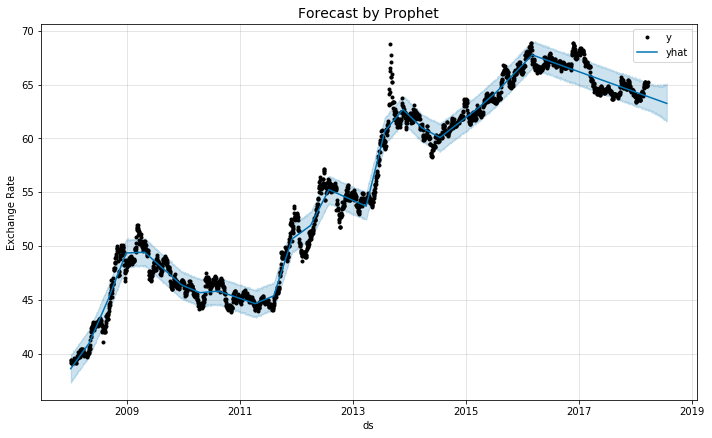

In [189]:
prophet_model.plot(forecast, uncertainty=True)
plt.title('Forecast by Prophet', fontsize=14)
plt.legend()
plt.ylabel('Exchange Rate')
plt.show()


	 		 	 	 Prophet Model 		 		 	


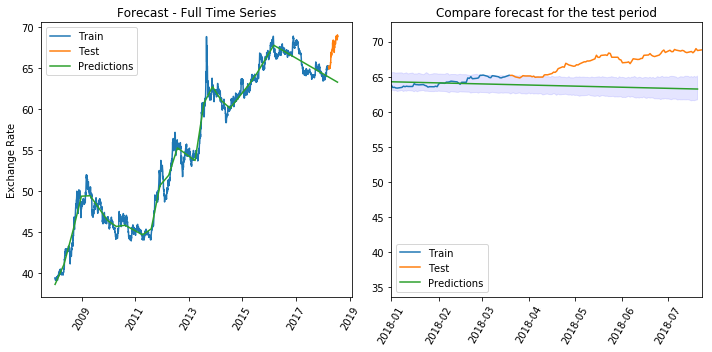

In [190]:
plot_prophet_predictions()

Prophet also allows the ability to decompose the data into different levels of seasonality/patterns. 

To see the forecast components, we can use the Prophet.plot_components method. Prophet tries to plot the trend, yearly seasonality, and weekly seasonality of the time series if available. If holidays were included, we could see those too.
Since we have set seasonality parameters false in the above call we don't see any separate plot for seasonality here.

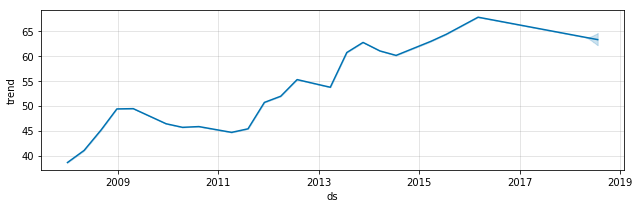

In [165]:
prophet_model.plot_components(forecast);

In [191]:
# Calculate MSE  df_prophet_test MSE:  14.7012033072
results = forecast[['ds', 'yhat']].merge(prophet_df, on='ds')
prophet_non_seas_mse = mean_squared_error(results.y, results.yhat)
print('MSE: ', prophet_non_seas_mse)

MSE:  1.38971804784


The parameter " changepoint_prior_scale " adjusts trend flexibility. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible where as Decreasing it will make the trend less flexible. Let's experiment with a range of values and see how the model changes.

# Evaluate across range of changepoint sensitivity

Linear growth prophet Model

ChangePoint 		 MSE
------------------------------
0.01 		 2.17239107353
0.05 		 1.38971804784
1.0 		 1.31117326505
10.0 		 1.3095008968


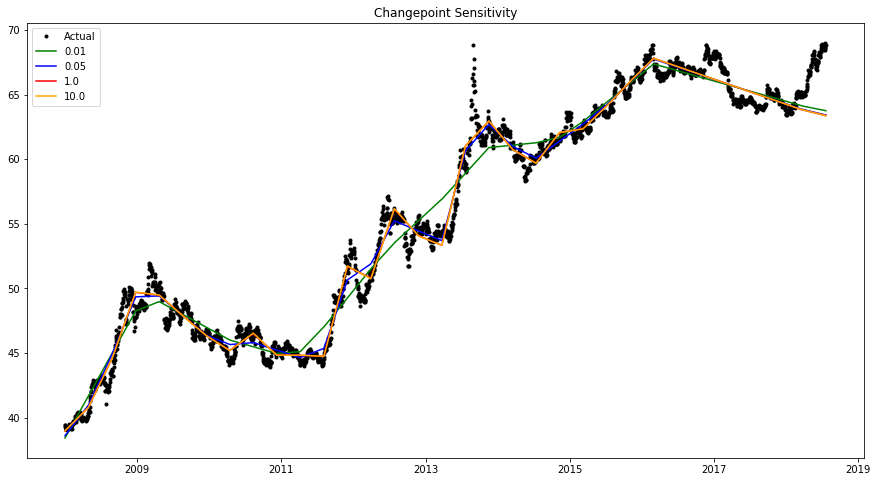

In [194]:

warnings.filterwarnings('ignore')
print('Linear growth prophet Model')
print()
changepoints = [ 0.01, 0.05, 1.0, 10.0]
print('ChangePoint \t\t MSE' )
print('-'* 30)
for cp in changepoints:
    mfg_prophet_CP = Prophet(growth='linear',
                             yearly_seasonality=False,
                             weekly_seasonality=False,
                             daily_seasonality=False,
                             changepoint_prior_scale=cp)
    
    mfg_prophet_CP.fit(df_prophet_train)
    future = mfg_prophet_CP.make_future_dataframe(periods=123)
    forecast = mfg_prophet_CP.predict(future)
    prophet_df[cp] = forecast['yhat']
    
    results = forecast[['ds', 'yhat']].merge(prophet_df, on='ds') #  df_prophet_test
    mse = mean_squared_error(results.y, results.yhat)
    
    print(cp, '\t\t' ,mse)

# Plot results
plt.figure(figsize=(15,8))

# Acual observations
plt.plot(prophet_df['ds'], prophet_df['y'], '.', color='black', label='Actual')

# Different changepoints
colors = {0.01: 'g', 0.05: 'b', 1.0: 'r', 10.0: 'orange'}
for cp in changepoints:
    plt.plot(prophet_df['ds'], prophet_df[cp], color=colors[cp], label=cp)

plt.title('Changepoint Sensitivity')
plt.legend()
plt.show()

We can see the changepoint setting makes a big difference in the model predictions. 


Let's try changing the growth parameter. It takes String 'linear' or 'logistic' to specify a linear or logistic trend.


In [52]:
linear_prophet_CP = Prophet(growth='linear',
                             yearly_seasonality=False,
                             weekly_seasonality=False,
                             daily_seasonality=False,
                             changepoint_prior_scale=0.05)
    
linear_prophet_CP.fit(df_prophet_train)
future = linear_prophet_CP.make_future_dataframe(periods=123)
forecast = linear_prophet_CP.predict(future)
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')
results = forecast[['ds', 'yhat']].merge(prophet_df, on='ds')
prophet_best_mse_linear = mean_squared_error(results.y, results.yhat)
print(prophet_best_mse_linear)


1.38971804784



	 		 	 	 Prophet Model 		 		 	


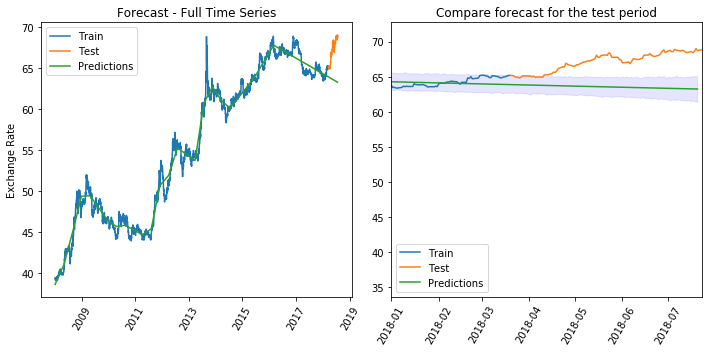

In [196]:
plot_prophet_predictions()

In [198]:
prophet_df = df_p.rename(columns={'DATE': 'ds', 'Exchange_rate': 'y'})
#prophet_df.head()
prophet_df['cap'] = prophet_df.y.max()
prophet_df['floor'] = prophet_df.y.min()
df_prophet_train = prophet_df[:-90]
df_prophet_test = prophet_df[-90:]
print(df_prophet_train.shape)
print(df_prophet_test.shape)

(2665, 4)
(90, 4)


Logistic growth prophet Model

ChangePoint 		 MSE
------------------------------
0.01 		 7.25741053307
0.05 		 3.69272327277
1.0 		 1.54558488308
10.0 		 1.52263301905


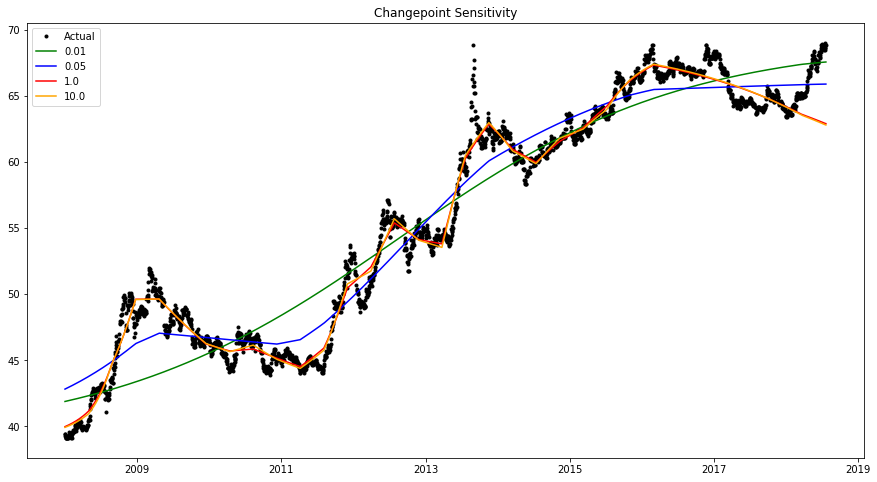

In [200]:
print('Logistic growth prophet Model')
print()
print('ChangePoint \t\t MSE' )
print('-'* 30)
for cp in changepoints:
    mfg_prophet_CP = Prophet(growth='logistic',
                             yearly_seasonality=False,
                             weekly_seasonality=False,
                             daily_seasonality=False,
                        changepoint_prior_scale=cp)
    mfg_prophet_CP.fit(df_prophet_train)
    future = mfg_prophet_CP.make_future_dataframe(periods=123)
    future['cap'] = prophet_df.y.max()
    future['floor'] = prophet_df.y.min()
    forecast = mfg_prophet_CP.predict(future)
    prophet_df[cp] = forecast['yhat']
    results = forecast[['ds', 'yhat']].merge(prophet_df, on='ds')
    mse = mean_squared_error(results.y, results.yhat)
    print(cp, '\t\t' ,mse)

# Plot results
plt.figure(figsize=(15,8))

# Acual observations
plt.plot(prophet_df['ds'], prophet_df['y'], '.', color='black', label='Actual')

# Different changepoints
colors = {0.01: 'g', 0.05: 'b', 1.0: 'r', 10.0: 'orange'}
for cp in changepoints:
    plt.plot(prophet_df['ds'], prophet_df[cp], color=colors[cp], label=cp)

plt.title('Changepoint Sensitivity')
plt.legend()
plt.show()

In [ ]:
# Lowest MSE was with growth = Logistic and default change point sensitivity = 0.05

In [201]:
prophet_model = Prophet(growth='logistic',
                        yearly_seasonality=False,
                        weekly_seasonality=False,
                        daily_seasonality=False,
                       changepoint_prior_scale = 1)

prophet_model.fit(df_prophet_train)
future = prophet_model.make_future_dataframe(periods=123)
future['cap'] = prophet_df.y.max()
future['floor'] = prophet_df.y.min()
forecast = prophet_model.predict(future)
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')
results = forecast[['ds', 'yhat']].merge(prophet_df, on='ds')
prophet_best_mse = mean_squared_error(results.y, results.yhat)
print(prophet_best_mse)

1.54558488308



	 		 	 	 Prophet Model 		 		 	


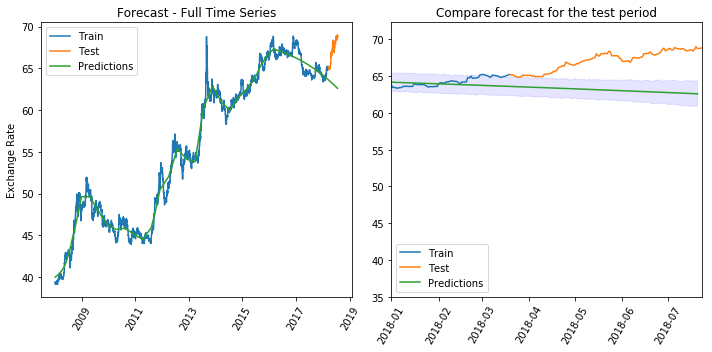

In [202]:
plot_prophet_predictions()

# Question

Is trend in this example a linear growth or logistic growth ?

# LSTM

LSTM network (Long Short-Term Memory Network) is a recurrent neural network, trained using Backpropagation Through Time. This overcomes the vanishing gradient problem.

We can phrase our time series analysis as a regression analysis. That is, given the exchange rate this month, what is the exchange rate next month?

We can write a simple function to convert our single column of data into a multi-column dataset: the first column containing this month’s (t) exchange rate and the second column containing next month’s (t+1) exchange rate , to be predicted. or so on.


Before we get started, let’s first import all of the functions and classes we intend to use. 

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [56]:
# fix random seed for reproducibility
np.random.seed(7)

In [57]:
df.head()

,Exchange_rate
DATE,
2008-01-01,39.41
2008-01-02,39.41
2008-01-03,39.26
2008-01-04,39.15
2008-01-07,39.15


In [58]:
dataset = df.copy()
dataset.head()

,Exchange_rate
DATE,
2008-01-01,39.41
2008-01-02,39.41
2008-01-03,39.26
2008-01-04,39.15
2008-01-07,39.15


# Normalize features -
LSTMs are sensitive to the scale of the input data. It can be a good practice to rescale the data . We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library

In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Let's split the data into train and test set.

In [60]:
lstm_train_data = dataset[:-90]
lstm_test_data = dataset[-90:]
print(len(lstm_train_data))
print(len(lstm_test_data))

2665
90


In [61]:
lstm_train_data_df = pd.DataFrame(lstm_train_data, index = df.Exchange_rate[:-90].index, columns = ['Exchange_rate'])
lstm_test_data_df = pd.DataFrame(lstm_test_data, index = df.Exchange_rate[-90:].index, columns = ['Exchange_rate'])

In [71]:
lstm_train_data_df.head(10)

,Exchange_rate
DATE,
2008-01-01,0.009702
2008-01-02,0.009702
2008-01-03,0.004684
2008-01-04,0.001004
2008-01-07,0.001004
2008-01-08,0.000335
2008-01-09,0.000335
2008-01-10,0.005018
2008-01-11,0.001004


In [74]:
lstm_train_data_df.shape

(2665, 1)

Now we can define a function to create new dataset.

The function takes two arguments: 

• dataset - a NumPy array that we want to convert into a dataset

• look_back - the number of previous time steps to use as input variables to predict the next time period — defaulted to 1.

In [62]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Look Back at one day data

In [63]:
look_back = 1
lstm_trainX, lstm_trainY = create_dataset(lstm_train_data, look_back)
lstm_testX, lstm_testY = create_dataset(lstm_test_data, look_back)
print(lstm_trainX.shape)
print(lstm_trainY.shape)

(2663, 1)
(2663,)


In [73]:
lstm_trainX

array([[ 0.00970224],
       [ 0.00970224],
       [ 0.00468384],
       ..., 
       [ 0.86082302],
       [ 0.86048846],
       [ 0.86383406]])

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features]. The first dimension is the length of values, the second is the number of time steps (lags), and the third is the number of predictors . Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [64]:
# reshape input to be [samples, time steps, features]
lstm_trainX = np.reshape(lstm_trainX, (lstm_trainX.shape[0], 1, lstm_trainX.shape[1]))
lstm_testX = np.reshape(lstm_testX, (lstm_testX.shape[0], 1, lstm_testX.shape[1]))
print(lstm_trainX.shape)
print(lstm_trainY.shape)

(2663, 1, 1)
(2663,)


We are now ready to design and fit our LSTM network for this problem. The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 64 is used.

In [65]:
# create and fit the LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(1, look_back)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(lstm_trainX, lstm_trainY, epochs=100, batch_size=64, verbose=2)

C:\Users\gyans\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 1/100
 - 3s - loss: 0.2438
Epoch 2/100
 - 0s - loss: 0.1665
Epoch 3/100
 - 0s - loss: 0.1166
Epoch 4/100
 - 0s - loss: 0.0830
Epoch 5/100
 - 0s - loss: 0.0659
Epoch 6/100
 - 0s - loss: 0.0586
Epoch 7/100
 - 0s - loss: 0.0515
Epoch 8/100
 - 0s - loss: 0.0510
Epoch 9/100
 - 0s - loss: 0.0499
Epoch 10/100
 - 0s - loss: 0.0459
Epoch 11/100
 - 0s - loss: 0.0426
Epoch 12/100
 - 0s - loss: 0.0446
Epoch 13/100
 - 0s - loss: 0.0396
Epoch 14/100
 - 0s - loss: 0.0371
Epoch 15/100
 - 0s - loss: 0.0353
Epoch 16/100
 - 0s - loss: 0.0321
Epoch 17/100
 - 0s - loss: 0.0294
Epoch 18/100
 - 0s - loss: 0.0296
Epoch 19/100
 - 0s - loss: 0.0294
Epoch 20/100
 - 0s - loss: 0.0242
Epoch 21/100
 - 0s - loss: 0.0258
Epoch 22/100
 - 0s - loss: 0.0242
Epoch 23/100
 - 0s - loss: 0.0224
Epoch 24/100
 - 0s - loss: 0.0227
Epoch 25/100
 - 0s - loss: 0.0210
Epoch 26/100
 - 0s - loss: 0.0196
Epoch 27/100
 - 0s - loss: 0.0182
Epoch 28/100
 - 0s - loss: 0.0168
Epoch 29/100
 - 0s - loss: 0.0180
Epoch 30/100
 - 0s - lo

Now since the model is fitted to the training data, let's predict for the train and test data and check the mean squared errors for both set.

In [66]:
trainPredict = lstm_model.predict(lstm_trainX)
testPredict = lstm_model.predict(lstm_testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
lstm_trainY = scaler.inverse_transform([lstm_trainY])
testPredict = scaler.inverse_transform(testPredict)
lstm_testY = scaler.inverse_transform([lstm_testY])
# calculate root mean squared error
trainScore = mean_squared_error(lstm_trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore))
lstm_1_lb_mse = mean_squared_error(lstm_testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (lstm_1_lb_mse))

Train Score: 1.19 MSE
Test Score: 0.98 MSE


In [81]:
len(lstm_testY[0])

88

Now plot the predictions.

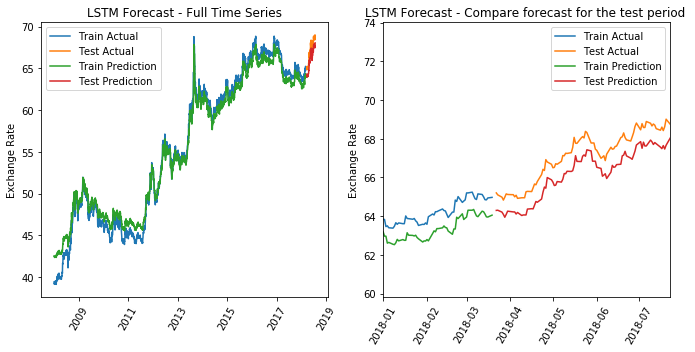

In [90]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(lstm_train_data_df.iloc[2:].index, lstm_trainY[0], label = 'Train Actual')
plt.plot(lstm_test_data_df.iloc[2:].index, lstm_testY[0], label = 'Test Actual')
plt.plot(lstm_train_data_df.iloc[2:].index, trainPredict[:,0], label = 'Train Prediction')
plt.plot(lstm_test_data_df.iloc[2:].index, testPredict[:,0], label = 'Test Prediction')
plt.title('LSTM Forecast - Full Time Series')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=60)
plt.legend()

plt.subplot(1,2,2)
plt.plot(lstm_train_data_df.iloc[2:].index, lstm_trainY[0], label = 'Train Actual')
plt.plot(lstm_test_data_df.iloc[2:].index, lstm_testY[0], label = 'Test Actual')
plt.plot(lstm_train_data_df.iloc[2:].index, trainPredict[:,0], label = 'Train Prediction')
plt.plot(lstm_test_data_df.iloc[2:].index, testPredict[:,0], label = 'Test Prediction')
plt.ylim(min(lstm_testY[0]) - 5, max(lstm_testY[0]) + 5)
plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 7, 23)])
plt.title('LSTM Forecast - Compare forecast for the test period ')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=60)
plt.tight_layout()
plt.legend()
plt.show()



# Look back one week data

In [256]:
look_back = 7
lstm_trainX_7, lstm_trainY_7 = create_dataset(lstm_train_data, look_back)
lstm_testX_7, lstm_testY_7 = create_dataset(lstm_test_data, look_back)
print(lstm_trainX_7.shape)
print(lstm_trainY_7.shape)

(2657, 7)
(2657,)


In [257]:
# reshape input to be [samples, time steps, features]
lstm_trainX_7 = np.reshape(lstm_trainX_7, (lstm_trainX_7.shape[0], 1, lstm_trainX_7.shape[1]))
lstm_testX_7 = np.reshape(lstm_testX_7, (lstm_testX_7.shape[0], 1, lstm_testX_7.shape[1]))
print(lstm_trainX_7.shape)
print(lstm_trainY_7.shape)

(2657, 1, 7)
(2657,)


In [258]:
# create and fit the LSTM network
lstm_model_7 = Sequential()
lstm_model_7.add(LSTM(4, input_shape=(1, look_back)))
lstm_model_7.add(Dropout(0.3))
lstm_model_7.add(Dense(1))
lstm_model_7.compile(loss='mean_squared_error', optimizer='adam')
lstm_model_7.fit(lstm_trainX_7, lstm_trainY_7, epochs=100, batch_size=64, verbose=2)


C:\Users\gyans\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch 1/100
 - 1s - loss: 0.3268
Epoch 2/100
 - 0s - loss: 0.1841
Epoch 3/100
 - 0s - loss: 0.1044
Epoch 4/100
 - 0s - loss: 0.0762
Epoch 5/100
 - 0s - loss: 0.0563
Epoch 6/100
 - 0s - loss: 0.0461
Epoch 7/100
 - 0s - loss: 0.0492
Epoch 8/100
 - 0s - loss: 0.0404
Epoch 9/100
 - 0s - loss: 0.0402
Epoch 10/100
 - 0s - loss: 0.0399
Epoch 11/100
 - 0s - loss: 0.0356
Epoch 12/100
 - 0s - loss: 0.0320
Epoch 13/100
 - 0s - loss: 0.0316
Epoch 14/100
 - 0s - loss: 0.0319
Epoch 15/100
 - 0s - loss: 0.0286
Epoch 16/100
 - 0s - loss: 0.0291
Epoch 17/100
 - 0s - loss: 0.0294
Epoch 18/100
 - 0s - loss: 0.0261
Epoch 19/100
 - 0s - loss: 0.0260
Epoch 20/100
 - 0s - loss: 0.0247
Epoch 21/100
 - 0s - loss: 0.0258
Epoch 22/100
 - 0s - loss: 0.0227
Epoch 23/100
 - 0s - loss: 0.0216
Epoch 24/100
 - 0s - loss: 0.0228
Epoch 25/100
 - 0s - loss: 0.0220
Epoch 26/100
 - 0s - loss: 0.0202
Epoch 27/100
 - 0s - loss: 0.0201
Epoch 28/100
 - 0s - loss: 0.0190
Epoch 29/100
 - 0s - loss: 0.0178
Epoch 30/100
 - 0s - lo

In [259]:
trainPredict_7 = lstm_model_7.predict(lstm_trainX_7)
testPredict_7 = lstm_model_7.predict(lstm_testX_7)
# invert predictions
trainPredict_7 = scaler.inverse_transform(trainPredict_7)
lstm_trainY_7 = scaler.inverse_transform([lstm_trainY_7])
testPredict_7 = scaler.inverse_transform(testPredict_7)
lstm_testY_7 = scaler.inverse_transform([lstm_testY_7])
# calculate root mean squared error
trainScore_7 = mean_squared_error(lstm_trainY_7[0], trainPredict_7[:,0])
print('Train Score: %.2f MSE' % (trainScore_7))
lstm_7_lb_mse = mean_squared_error(lstm_testY_7[0], testPredict_7[:,0])
print('Test Score: %.2f MSE' % (lstm_7_lb_mse))

Train Score: 1.07 MSE
Test Score: 2.30 MSE


In [98]:
len(lstm_testY_7[0])

82

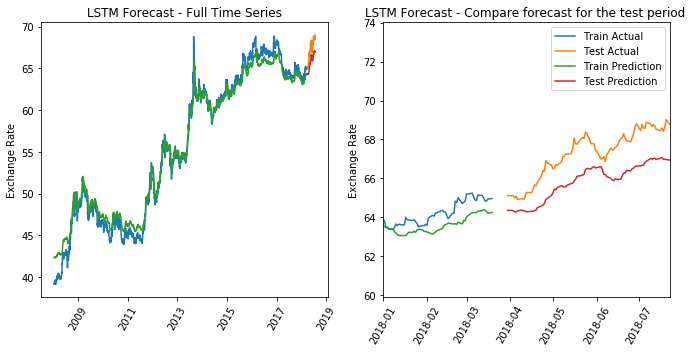

In [101]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)

plt.plot(lstm_train_data_df.iloc[8:].index, lstm_trainY_7[0], label = 'Train Actual')
plt.plot(lstm_test_data_df.iloc[8:].index, lstm_testY_7[0], label = 'Test Actual')
plt.plot(lstm_train_data_df.iloc[8:].index, trainPredict_7[:,0], label = 'Train Prediction')
plt.plot(lstm_test_data_df.iloc[8:].index, testPredict_7[:,0], label = 'Test Prediction')
plt.title('LSTM Forecast - Full Time Series')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=60)

plt.subplot(1,2,2)
plt.plot(lstm_train_data_df.iloc[8:].index, lstm_trainY_7[0], label = 'Train Actual')
plt.plot(lstm_test_data_df.iloc[8:].index, lstm_testY_7[0], label = 'Test Actual')
plt.plot(lstm_train_data_df.iloc[8:].index, trainPredict_7[:,0], label = 'Train Prediction')
plt.plot(lstm_test_data_df.iloc[8:].index, testPredict_7[:,0], label = 'Test Prediction')
plt.ylim(min(lstm_testY_7[0]) - 5, max(lstm_testY_7[0]) + 5)
plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 7, 23)])
plt.title('LSTM Forecast - Compare forecast for the test period ')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=60)
plt.tight_layout()
plt.legend()
plt.show()


# Question
Is the below explanation  (for - mse increase when look back increased) OK ? Can u rephrase this ?

when using more history data to predict for the future days, the error term is increasing. This can be attributed to the fact that recent observations play important role in predicting future.

# COMPARE the models

In [37]:
best_arima = arima_model_output_df.sort_values(by= 'MSE', ascending=True).head(1)
best_arima_mse = best_arima.MSE.values[0]
best_arima_aic = best_arima.AIC.values[0]
best_arima_model = best_arima.Param.values[0]

In [38]:
best_arima

,AIC,MSE,Param
11,940.70697,3.335052,"(1, 1, 0)"


In [40]:
arima_model_output_df.sort_values(by= 'AIC', ascending=True).head(1)

,AIC,MSE,Param
18,907.173651,3.373355,"(2, 1, 2)"


In [260]:
model_comp_df = pd.DataFrame({
    'Model' : ['ARIMA', 'AUTO_ARIMA', 'PROPHET', 'LSTM_1_look_back','LSTM_7_look_back' ],
    'AIC_Value' : [best_arima_aic,auto_arima_aic_1, np.nan,np.nan,np.nan],
    'Mean_Squared_error' : [best_arima_mse,auto_arima_1_mse, prophet_best_mse_linear, lstm_1_lb_mse, lstm_7_lb_mse]
}, columns = ['Model','AIC_Value','Mean_Squared_error'])
model_comp_df

,Model,AIC_Value,Mean_Squared_error
0,ARIMA,940.706970,3.335052
1,AUTO_ARIMA,976.279331,3.399531
2,PROPHET,NaN,1.389718
3,LSTM_1_look_back,NaN,0.980652
4,LSTM_7_look_back,NaN,2.300942


In [261]:
model_comp_df.sort_values(by= 'Mean_Squared_error')

,Model,AIC_Value,Mean_Squared_error
3,LSTM_1_look_back,NaN,0.980652
2,PROPHET,NaN,1.389718
4,LSTM_7_look_back,NaN,2.300942
0,ARIMA,940.706970,3.335052
1,AUTO_ARIMA,976.279331,3.399531


The LSTM model with 1 day look back, provided the lowest mean squared error. 

# Conclusion

We have looked at a large range of ARIMA configurations as well as more powerful forecasting tool developed by the Facebook. We also looked at the LSTM Neural Network model. All of the models did fairly well. The LSTM model performed the best for this dataset. We can achieve some more improvements in LSTM model . We can try some parameter tuning in LSTM models or adding layers of LSTM blocks etc. 